<a href="https://colab.research.google.com/github/aminghafari1/lcaging-fmri/blob/main/visual_outlier_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import numpy as np
import glob
import os
def substring_after(s,delim):
  return s.partition(delim)[2]
def substring_before(s,delim):
  return s.partition(delim)[0]
import scipy.io as sio
import os
from scipy.stats import zscore
from os import path
import pandas as pd
import matplotlib.pyplot as plt
import csv
import time
from IPython.display import clear_output

Mounted at /content/gdrive


In [30]:
base_dir=glob.glob('/content/gdrive/Shareddrives/LC-Aging/LC_aging_fMRI/')
base_dir=base_dir[0]
deficient_subs=[]
prefix = 'BAP'
sub_folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f)) and f.startswith(prefix)]
sub_folders = [base_dir + i for i in sub_folders]
visual_files=[]
accuracy_results="updated_visual_accuracy.csv"
for dir in sub_folders:
    vis_dir = os.path.join(dir, 'visual')
    if os.path.exists(vis_dir):
       accuracy_csv=os.path.join(vis_dir, accuracy_results) 
       if os.path.exists(accuracy_csv) == True:
         visual_files.append(accuracy_csv)
number_of_run=5 ##each subject has 5 runs ideally
number_of_stimulus_levels=5 ##each run has 5 different stimulus levels
accuracy_matrix = np.zeros((len(visual_files), number_of_run, number_of_stimulus_levels))
layer_subjects={}
for i in range(len(visual_files)):
  temp=substring_before(visual_files[i],"/vis")
  subject_index=substring_after(temp,"MRI/")
  accuracy_csv=visual_files[i]
  with open(accuracy_csv, 'r') as file:
   reader=csv.reader(file)
   matrix = np.array(list(reader))
   matrix[matrix == ''] = '0'
   matrix_float = matrix.astype('float')
   matrix_float = matrix_float[1:, 1:]
   layer_subjects[i]=subject_index
   if np.shape(matrix_float)!=(number_of_run,number_of_stimulus_levels):
     print(np.shape(matrix_float))
     num_rows_to_add=number_of_run-np.shape(matrix_float)[0]
     zeros_matrix = np.zeros((num_rows_to_add, matrix_float.shape[1]))
     matrix_float=np.concatenate((matrix_float, zeros_matrix), axis=0)
   accuracy_matrix[i,:,:]=matrix_float

   
   

  

(3, 5)
(4, 5)


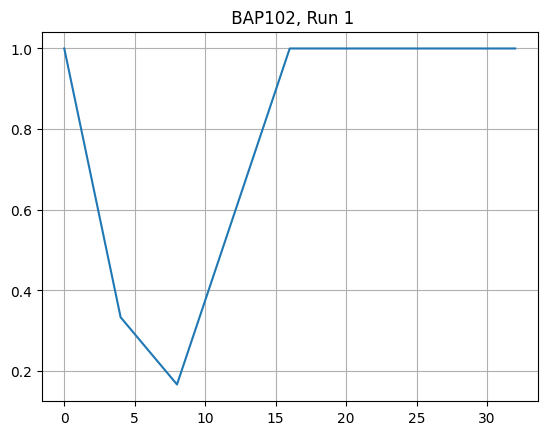

KeyboardInterrupt: ignored

In [31]:
## plotting the results
x=[0,4,8,16,32]
import time
from IPython.display import clear_output
for i in range(accuracy_matrix.shape[0]):
    # Loop through each row of the layer
    for j in range(accuracy_matrix.shape[1]):
        # Extract the y values for the current row
        figure, ax = plt.subplots(figsize=(10, 8))
        y = accuracy_matrix[i, j, :]
        line1, = ax.plot(x, y)
        # Plot x by y
        plt.close()
        plt.plot(x, y)
        plt.grid(True)
        plt.title(f" {layer_subjects[i]}, Run {j}")
        plt.show()
        figure.canvas.draw()
        figure.canvas.flush_events()
        time.sleep(1.5)
        clear_output(wait=True)

In [23]:
orig_shape=accuracy_matrix.shape
data=np.reshape(accuracy_matrix,(orig_shape[0]*orig_shape[1],orig_shape[2]))

i is 189


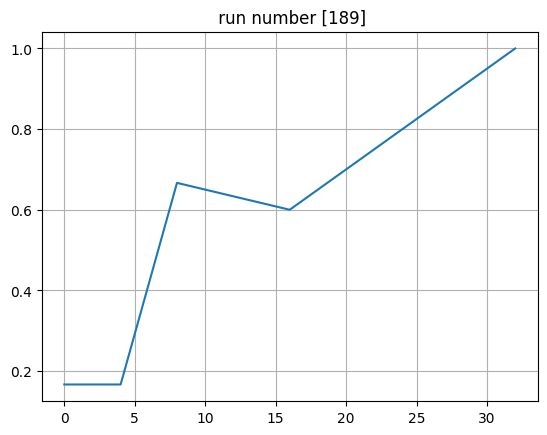

In [ ]:
a## Method 1: Mahalanobis Distance
## calculate the mean of the data
import time
from IPython.display import clear_output
contrast=[0,4,8,16,32]
mean=np.mean(data,axis=0)
## calculate the malahobis distance between each row and the mean and save it in a matrix named mahal
mahal=np.zeros((len(data),1))
for i in range(len(data)):
    mahal[i]=np.sqrt((data[i]-mean).T.dot(np.linalg.inv(np.cov(data.T))).dot((data[i]-mean)))
## plot the mahalobis distance
plt.plot(mahal)
plt.grid(True)
plt.title(f" mahalobis distance")
plt.show()
time.sleep(2)
clear_output(wait=True)
## find the outliers based on the mahalobis distance
mahal_outliers=[]
for i in range(len(mahal)):
    if mahal[i]>np.mean(mahal)+3*np.std(mahal):
        mahal_outliers.append(i)
## plot the outliers
for i in mahal_outliers:
    print("i is %d" %(i))
    figure, ax = plt.subplots(figsize=(10, 8))
    y = data[i]
    x=contrast
    line1, = ax.plot(x, y)
        # Plot x by y
    plt.close()
    plt.plot(x, y)
    plt.grid(True)
    plt.title(f" run number {[i]}")
    plt.show()
    figure.canvas.draw()
    figure.canvas.flush_events()
    time.sleep(2)
    clear_output(wait=True)

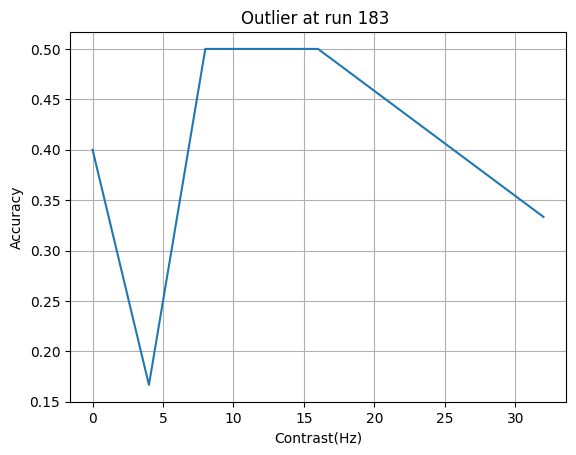

In [70]:
## First of all, I need to remove nonzero rows
nonzero_rows = np.any(data, axis=1)
nonzero_data = data[nonzero_rows]
## now doing Sn calculations based on nonzeros
from scipy.spatial import distance
contrast=[0,4,8,16,32]
ind_med = []
n=np.shape(nonzero_data[:,0])[0]    
all_distances = np.zeros((n,n))

for i in range(len(nonzero_data)):
    temp=np.zeros(len(nonzero_data))
    absolute_distance = np.zeros(len(nonzero_data))
    for j in range(len(temp)):
        temp[j]=distance.euclidean(nonzero_data[i], nonzero_data[j])
    all_distances[i]=temp
    temp_sorted=np.sort(temp)
    median_temp=np.median(temp_sorted[1:])
    ind_med.append(median_temp)
Sn = np.median(ind_med)
c=n/(n-0.9)        
Sn_criterion=Sn*c
lambda1=1.9
outliers=[]
for i in range(len(ind_med)):
    if (ind_med[i]/Sn_criterion) > lambda1:
        outliers.append(i)
import time
from IPython.display import clear_output
for i in range(len(outliers)):
    plt.plot(contrast, nonzero_data[outliers[i]], label='Subject '+str(outliers[i]))
    plt.grid(True)
    plt.ylabel('Accuracy')
    plt.xlabel('Contrast(Hz)')
    plt.title(f"Outlier at run {outliers[i]} ")
    plt.show()
    time.sleep(1.5)
    clear_output(wait=True)

In [71]:
Sn_criterion

0.5295284412631509

In [64]:
num_rows=(np.shape(outliers)[0]//2)+np.shape(outliers)[0]%2
fig, ax= plt.subplots(num_rows, 2, figsize=(10, 10))
for i, ax in enumerate(ax.flatten()):
  sub_index=layer_subjects[outliers[i]//np.shape(data)[1]]
  run_index=outliers[i]%np.shape(data)[1]
  y=data[outliers[i]]
  ax.plot(contrast,y)
  ax.set_title(f'{sub_index} run {run_index}')
  ax.set_xlabel('oddball level(Hz)')
  ax.set_ylabel('Accuracy')
  ax.grid(True)
plt.tight_layout()
plt.show()

[69, 88, 89, 120, 150]

In [72]:
k=0
for i in range(len(data)):
  if np.all(data[i]==0):
    continue
  temp=np.zeros(len(nonzero_data))
  absolute_distance = np.zeros(len(nonzero_data))
  for j in range(len(temp)):
      temp[j]=distance.euclidean(nonzero_data[k], nonzero_data[j])
  all_distances[k]=temp
  temp_sorted=np.sort(temp)
  median_temp=np.median(temp_sorted[1:])
  ind_med.append(median_temp)
  k=k+1
Sn = np.median(ind_med)
c=n/(n-0.9)        
Sn_criterion=Sn*c
lambda1=1.9
outliers=[]
for i in range(len(ind_med)):
    if (ind_med[i]/Sn_criterion) > lambda1:
        outliers.append(i)
import time
from IPython.display import clear_output
for i in range(len(outliers)):
    plt.plot(contrast, nonzero_data[outliers[i]], label='Subject '+str(outliers[i]))
    plt.grid(True)
    plt.ylabel('Accuracy')
    plt.xlabel('Contrast(Hz)')
    plt.title(f"Outlier at run {outliers[i]} ")
    plt.show()
    time.sleep(1.5)
    clear_output(wait=True)

IndexError: ignored

In [73]:
Sn_criterion

0.5295284412631509

In [74]:
np.shape(nonzero_data)

(192, 5)